In [4]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib 
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt

In [5]:
def gaussian_sample(mean, sigma, size):
    return np.random.normal(mean, sigma, size)

### Example 1: K-means optimizes for intra-cluster distance
Running the code block below, you will see that in spite of choosing k=3, the algorithm will often assign 2 centroids to what is actually a single cluster. **Consider the differences in the distributions of data below and explain why this phenomenon might be occurring.**

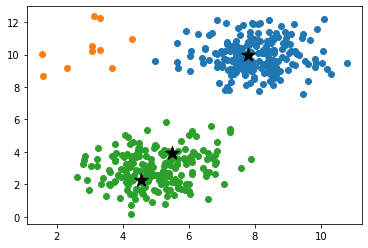

In [6]:
class_1 = gaussian_sample([8, 10], [1, 1], [200, 2])
class_2 = gaussian_sample([3, 10], [1, 1], [10, 2])
class_3 = gaussian_sample([5, 3], [1, 1], [200, 2])
X = np.vstack([class_1, class_2, class_3])
kmeans = KMeans(n_clusters = 3, init = 'random', n_init = 1).fit(X)

plt.scatter(*class_1.T)
plt.scatter(*class_2.T)
plt.scatter(*class_3.T)
plt.scatter(*kmeans.cluster_centers_.T, s = 200, marker = '*', c = 'black')

#### Start example-1 answer ####

The blue and green clusters are much larger than the orange cluster. The K-means algorithm optimizes its clustering to minimize the intra-cluster distance. In cases like this example, where there are cluster size imbalances, the K-means algorithm achieves a solution where 2 cluster centroids are assigned to what is actually a single cluster. This allows the algorithm to reduce distances to the cluster center within a larger cluster, which outweighs the larger cost incurred on the orange datapoints.

#### End example-1 answer ####

### Example 2: Random Restarts with K-Means
To address the issue in Example 1, we can improve the algorithm's performance by running K-means multiple times with different random initializations. The final chosen clusters will be the one that achieves the smallest cost for the objective function - minimizing the squared sum distances of the data points to the cluster centroids. 

This is easily implemented using the the sklearn KMeans function with the n_init parameter, which defines the number of random restarts that the algorithm will perform. **Set the value for the n_init parameter in the KMeans function below.** 

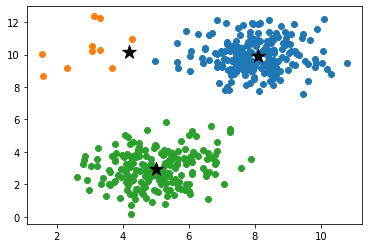

In [7]:
plt.scatter(*class_1.T)
plt.scatter(*class_2.T)
plt.scatter(*class_3.T)
## TODO: SET THE N_INIT PARAMETER BELOW ##
kmeans = KMeans(n_clusters = 3, init = 'random', n_init = 10).fit(X)
## END TODO ##
plt.scatter(*kmeans.cluster_centers_.T, s = 200, marker = '*', c = 'black')

### Example 3: Feature lifting with K-means
Below, we will see how K-means performs on circularly separable data. Running K-means on the original data of 2 concentric circles results in the clustering below. In these demos, each of the colors represent how the algorithm separated the data, where the stars denote the centroids of the clusters. 

Running ordinary K-means on the original dataset of (x,y) coordinates results in the clustering below. **Comment on the performance below.**

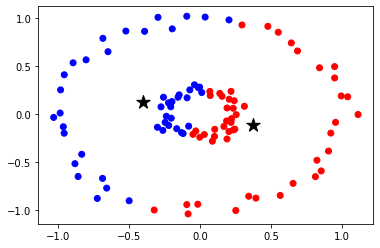

In [8]:
X, Y = datasets.make_circles(noise = 0.05, factor = 0.25)
kmeans = KMeans(n_clusters = 2, init = 'random').fit(X)
predictions = kmeans.predict(X)
colors = ['red', 'blue']
plt.scatter(*X.T, c = predictions, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(*kmeans.cluster_centers_.T, s = 200, marker = '*', c = 'black')

#### Start Example-3,1 Answer ####

The K-means algorithm does not correctly cluster the data points above. It forces a linear boundary and places the centroids on opposite sides between the inner and outer circles to minimize cluster distances.


#### End Example-3,1 Answer ####

#### Ordinary Polynomial Feature Augmentation 
As we've seen with regression techniques, we can try lifting the feature space. In this case, a natural thought might be to lift the feature space using the radius-squared feature (summing the squares of the coordinates). **Comment on the performance of this strategy below and why this might result.**

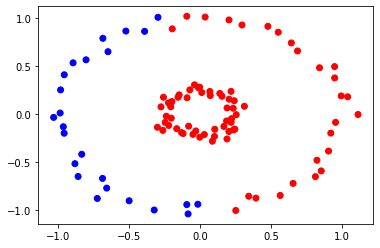

In [9]:
X_aug = np.hstack([X, np.sum(X ** 2, axis = 1).reshape(100,1)])
kmeans_lifted = KMeans(n_clusters = 2).fit(X_aug)
predictions = kmeans_lifted.predict(X_aug)
colors = ['red', 'blue']
plt.scatter(*X.T, c = predictions, cmap=matplotlib.colors.ListedColormap(colors))

#### Start Example-3,2 Answer ####

Although we are lifting the feature space and the radius-squared feature should separate the data into identifiable clusters, the K-means algorithm is still trying to minimize intra-cluster distances for the (x,y) coordinates (which are still included in the dataset). For this reason, the clustering that results doesn't look all that different than the clustering in the previous part. We need to have a systematic way of removing the features (i.e. (x,y) coordinates) that don't actually help us with the clustering problem we're trying to solve.

#### End Example-3,2 Answer ####

#### Manually selecting an appropriate feature
Looking at the feature set above, the radius-squared feature is what would actually help us differentiate between the clusters. Let us try running K-means again using only the radius-squared feature. **Comment on the performance of this strategy below and why this might result.**

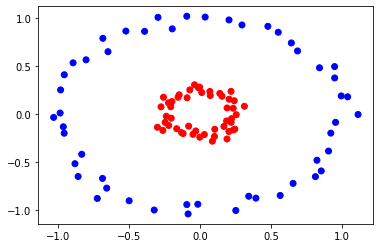

In [10]:
X_aug = np.sum(X ** 2, axis = 1)
kmeans_lifted = KMeans(n_clusters = 2).fit(X_aug.reshape(-1,1))
predictions = kmeans_lifted.predict(X_aug.reshape(-1,1))
colors = ['red', 'blue']
plt.scatter(*X.T, c = predictions, cmap=matplotlib.colors.ListedColormap(colors))

#### Start Example-3,3 Answer ####

This strategy performs clustering as we would expect! We were able to manually transform the dataset into points that are clusterable for the K-means algorithm, using the radius-squared feature. The inner circle all correspond to smaller positive values and the outer circle all correspond to larger positive values. In this case, we were able to manually construct the feature that helps separate our data, this may not always be feasible. The next part helps us generalize this step.

#### End Example-3,3 Answer ####

#### Using Kernel PCA to lift & reduce the dimensionality
We cannot always manually construct and select the feature that will help separate the data. In this case, we will use KernelPCA with the RBF Kernel. This allows us to perform non-linear dimensionality reduction. We can then run KMeans in this reduced space to cluster the data.

The first graph shows the projection of data points into 2-D PCA space. The second graph visualizes how the original data points were clustered using the PCA + K-means strategy. **Comment on the results of this strategy.**

Points projected into PCA Space


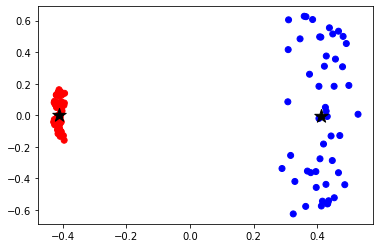

Output of Clustering Algorithm in Original Space


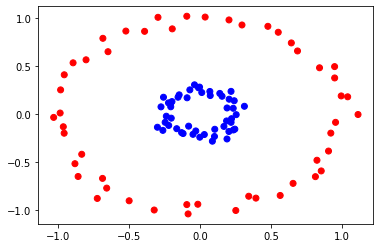

In [11]:
## TODO: TUNE A VALUE OF GAMMA THAT CREATES SEPARABLE CLUSTERS FOR K-MEANS ##
kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 5)
## END TODO ##

projected_data = kpca.fit_transform(X)
plt.scatter(*projected_data.T, c = Y, cmap=matplotlib.colors.ListedColormap(colors))

print("Points projected into PCA Space")
kmeans_pca = KMeans(n_clusters = 2).fit(projected_data)
predictions = kmeans_pca.predict(projected_data)
plt.scatter(*kmeans_pca.cluster_centers_.T, s = 200, marker = '*', c = 'black')
plt.show()

print("Output of Clustering Algorithm in Original Space")
plt.scatter(*X.T, c = predictions, cmap=matplotlib.colors.ListedColormap(colors))

#### Start Example-3,3 Answer ####
The Kernel PCA projects the data points into a space that generates identifiable clusters. Then, running K-means on this data, we are able to generate cluster centers in this space that appropriately separate the points from the inner and outer circles. In the second plot, we visualize that the clustering indeed works correctly in the original space. In this example, it produces the same results as manually selecting the radius-squared feature.
#### End Example-3,3 Answer ####

## Variations of k-Means: Kernelized k-Means

Recall how kernels are a more efficient way for model calculations through the computation of inner products. Please read through Section 2.1 in the paper below to understand how kernelized k-Means works, particularly focusing on the update step. Below is a FLAWED implementation of kernelized k-Means. Please locate the bugs and correct them so that the function works as intended.

Link to paper: https://www.cs.utexas.edu/users/inderjit/public_papers/kdd_spectral_kernelkmeans.pdf

In [15]:
def k_means_kernelized(data, k, max_iter = 1000, weights = None, kernel_type = "linear"):
    n = len(data)
    # Randomize initial clusters
    random_state = check_random_state(None)
    labels = np.random.randint(k, size = n)

    # Initialize kernel
    kernel = pairwise_kernels(data, None, kernel_type)

    # Set weights if not defined to be all 1s (no preference)
    if not weights:
        weights = np.ones(n)

    # Inter/Intra Cluster distance storage
    intra_dist = np.zeros((n, k))
    inter_dist = np.zeros(k)

    for i in range(max_iter):
        intra_dist.fill(0)
        for cluster in range(k):
            # This is our mask to isolate the points currently in cluster j
            cluster_points = labels == cluster

            # If k is too large, we may have empty clusters!
            if np.sum(cluster_points) == 0:
                return "Empty cluster!"

            size = np.count_nonzero(cluster_points)
            cluster_kernel = kernel[cluster_points][:, cluster_points]

            # This is our distance update step using the kernel trick!
            this_cluster_dist = np.sum(np.outer(weights[cluster_points], weights[cluster_points]) * cluster_kernel / size ** 2)
            inter_dist[cluster] = this_cluster_dist

            # Update step
            intra_dist[:, cluster] += this_cluster_dist 
            intra_dist[:, cluster] -= 2 * np.sum(weights[cluster_points] * kernel[:, cluster_points], axis = 1) / size

    # If none of the labels were updated, we are done.  
        previous_labels = labels[:]
        labels = intra_dist.argmin(axis = 1)
        if np.sum((labels - previous_labels) == 0) == 0:
            break

    return np.array(labels)

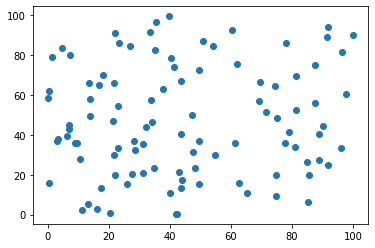

In [16]:
# Code to test the function. Random 2D data is generated in this simple case.
data = 100 * np.random.rand(100, 2)
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4: "orange", 5: 'purple', 6: 'black', 7: 'pink'}
plt.scatter(data[:, 0], data[:, 1])

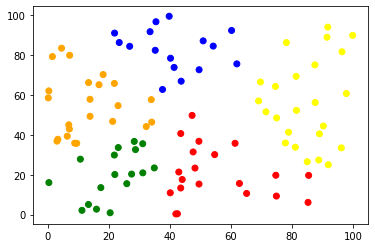

In [17]:
# If the function is correctly fixed, distinct clusters should be seen.
labels = k_means_kernelized(data, 5, 1000)
color_labels = np.vectorize(colors.get)(labels)
color_labels
plt.scatter(data[:, 0], data[:, 1], c = color_labels)


Question: Try the kernelized clustering with different parameters. What happens when:
        
<ul>    
<li>The number of clusters is reduced from 5 to 3?</li>
<li>An RBF kernel is used instead of a linear one?</li>
<li>max_iter is reduced to 100 or increased to 10000?</li>
    
</ul>